# Convolutional Autoencoder Lines

Let's use an autoencoder for the Lines dataset. 

The first experiment imports the 2D data points and casts them into a 1D vector. The (x,y) coordinates are mapped into successive inputs. They are hence correlated... This apparently is tremendously difficult to reconstruct for the autoencoder. Why? In the end it is just a difference between input and output. 

The nonnegative sparse constraints are not gonna help much. We really need not to throw away the 2D spatial correlations.

In [1]:
from keras.datasets import mnist
import numpy as np
import h5py
#from matplotlib.mlab import griddata
from scipy.interpolate import griddata

filename = '/home/anne/data/h5/lines.h5'
f = h5py.File(filename, 'r')
#for key in f.keys():
#    print(key)
data = np.array(f["data"])

map_to_grid = 1

def pnts2grid(x, y, resX=28, resY=28):
    xrange = np.linspace(0, resX - 1, 1)
    yrange = np.linspace(0, resY - 1, 1)
    Z = np.zeros((resX, resY))
    for i in range(len(x)):
        xpixel = round((x[i] - min(x)) / (max(x) - min(x)) * resX - 1).astype('int')
        ypixel = round((y[i] - min(y)) / (max(y) - min(y)) * resY - 1).astype('int')
        Z[xpixel,ypixel] = 1
    return Z

# Training and test set are 2D points. There are 100 images with 2D points. Each image contains 200 points. Each
# point contains an x and a y coordinate.
N = 100

if map_to_grid:
    resX = resY = 28
    z = np.zeros((N, resX, resY))
    for i in range(N):
        x = data[i,:,0]
        y = data[i,:,1]
        z[i,:,:] = pnts2grid(x, y, resX, resY)
    x_train = z[0:80]
    x_test  = z[80:N]
else:
    x_train = data[0:80]
    x_test  = data[80:N]


if map_to_grid:
    # Print one particular input to check if the discretization to a 28x28 grid went okay
    zfig=x_train[1]
    import matplotlib.pyplot as plt
    plt.imshow(zfig, interpolation='nearest', cmap='Blues',
        extent=(0.5,np.shape(zfig)[0]+0.5,0.5,np.shape(zfig)[1]+0.5))
    plt.colorbar()
    plt.show()
    
# Make them into 32-bit floats
#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 

# Create 1-dimensional vector of input, the coordinates are just fed into subsequent input nodes
# The (...,-1) is to indicate to Keras that we want to flatten the remaining dimensions to one (product under the hood)
# The layers are fully connected, so that is why we map to 1D. More dimensions only make sense if the layers
# are not densely connected.
#x_train = x_train.reshape((x_train.shape[0], -1))
#x_test = x_test.reshape((x_test.shape[0], -1))
if map_to_grid:
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     
else:
    x_train = np.reshape(x_train, (len(x_train), 200, 2, 1)) 
    x_test = np.reshape(x_test, (len(x_test), 200, 2, 1))     
    
print(x_train.shape)
print(x_test.shape)

input_size = x_train[0].shape
print(input_size)
#input_size = (28, 28, 1)

Using TensorFlow backend.


<Figure size 640x480 with 2 Axes>

(80, 28, 28, 1)
(20, 28, 28, 1)
(28, 28, 1)


In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import initializers

# this is the size of our encoded representations 
encoding_dim = (4,4,8)
batch_size = 100
epochs = 5000

# this is our input placeholder
input_img = Input(shape=(input_size))

convolution_shape = (3, 3)
pooling_shape = (2, 2)

# "encoded" is the encoded representation of the input
x = Conv2D(16, convolution_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D(pooling_shape, padding='same')(x)
x = Conv2D(8, convolution_shape, activation='relu', padding='same')(x)
x = MaxPooling2D(pooling_shape, padding='same')(x)
x = Conv2D(8, convolution_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D(pooling_shape, padding='same')(x)

# "decoded" is the lossy reconstruction of the input

x = Conv2D(8, convolution_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D(pooling_shape)(x)
x = Conv2D(8, convolution_shape, activation='relu', padding='same')(x)
x = UpSampling2D(pooling_shape)(x)
#x = Conv2D(16, convolution_shape, activation='relu', padding='same')(x)
x = Conv2D(16, convolution_shape, activation='relu')(x)
x = UpSampling2D(pooling_shape)(x)
decoded = Conv2D(1, convolution_shape, activation='sigmoid', padding='same')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [3]:
# this model maps an input to its encoded representation
#encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
#encoded_input = Input(shape=(encoding_dim))
# retrieve the last layer of the autoencoder model
#decoder_layer = autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
# types of optimizers:
#  adam
#  adagrad
#  sgd
# types of losses:
# - mean_absolute_error (gets all zeros)
# - hinge, squared_hinge
# - logcosh
# - kullback_leibler_divergence (gets all ones)
# - binary_crossentropy (adam/adagrad gets somewhere when cast to a grid)
# - poisson (as well)
# - cosine_proximity (vague)
# - mean_squared_logarithmic_error
#autoencoder.compile(optimizer='adagrad', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='poisson')

In [5]:
# the autoencoder should learn to map the x_train input data to x_train as output
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                validation_data=(x_test, x_test))

Train on 80 samples, validate on 20 samples
Epoch 1/5000
80/80 [==============================] - 0s 6ms/step - loss: 0.5714 - val_loss: 0.5680
Epoch 2/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.5689 - val_loss: 0.5661
Epoch 3/5000
80/80 [==============================] - 0s 3ms/step - loss: 0.5670 - val_loss: 0.5646
Epoch 4/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.5654 - val_loss: 0.5633
Epoch 5/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.5642 - val_loss: 0.5622
Epoch 6/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.5631 - val_loss: 0.5612
Epoch 7/5000
80/80 [==============================] - 0s 3ms/step - loss: 0.5621 - val_loss: 0.5602
Epoch 8/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.5612 - val_loss: 0.5591
Epoch 9/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.5601 - val_loss: 0.5578
Epoch 10/5000
80/80 [==============================] - 0

Epoch 82/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2929 - val_loss: 0.2900
Epoch 83/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2921 - val_loss: 0.2891
Epoch 84/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2913 - val_loss: 0.2882
Epoch 85/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2905 - val_loss: 0.2874
Epoch 86/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2898 - val_loss: 0.2865
Epoch 87/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2889 - val_loss: 0.2858
Epoch 88/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2882 - val_loss: 0.2851
Epoch 89/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2875 - val_loss: 0.2845
Epoch 90/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2869 - val_loss: 0.2839
Epoch 91/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2863 - val_los

Epoch 163/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2652 - val_loss: 0.2645
Epoch 164/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2650 - val_loss: 0.2643
Epoch 165/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2647 - val_loss: 0.2641
Epoch 166/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2645 - val_loss: 0.2639
Epoch 167/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2643 - val_loss: 0.2638
Epoch 168/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2641 - val_loss: 0.2636
Epoch 169/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2639 - val_loss: 0.2634
Epoch 170/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2636 - val_loss: 0.2633
Epoch 171/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2634 - val_loss: 0.2631
Epoch 172/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2632

Epoch 244/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2500 - val_loss: 0.2552
Epoch 245/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2498 - val_loss: 0.2552
Epoch 246/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2497 - val_loss: 0.2551
Epoch 247/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2495 - val_loss: 0.2550
Epoch 248/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2494 - val_loss: 0.2549
Epoch 249/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2492 - val_loss: 0.2548
Epoch 250/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2490 - val_loss: 0.2547
Epoch 251/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2489 - val_loss: 0.2546
Epoch 252/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2487 - val_loss: 0.2545
Epoch 253/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2486

Epoch 325/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2378 - val_loss: 0.2488
Epoch 326/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2377 - val_loss: 0.2487
Epoch 327/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2376 - val_loss: 0.2487
Epoch 328/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2375 - val_loss: 0.2486
Epoch 329/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2374 - val_loss: 0.2485
Epoch 330/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2373 - val_loss: 0.2485
Epoch 331/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2371 - val_loss: 0.2485
Epoch 332/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2370 - val_loss: 0.2484
Epoch 333/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2369 - val_loss: 0.2483
Epoch 334/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2368

Epoch 406/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2305 - val_loss: 0.2451
Epoch 407/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2304 - val_loss: 0.2450
Epoch 408/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2304 - val_loss: 0.2452
Epoch 409/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2303 - val_loss: 0.2450
Epoch 410/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2303 - val_loss: 0.2452
Epoch 411/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2302 - val_loss: 0.2450
Epoch 412/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2301 - val_loss: 0.2451
Epoch 413/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2300 - val_loss: 0.2450
Epoch 414/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2300 - val_loss: 0.2449
Epoch 415/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2299

Epoch 487/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2256 - val_loss: 0.2460
Epoch 488/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2255 - val_loss: 0.2458
Epoch 489/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2255 - val_loss: 0.2460
Epoch 490/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2254 - val_loss: 0.2459
Epoch 491/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2254 - val_loss: 0.2460
Epoch 492/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2253 - val_loss: 0.2460
Epoch 493/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2252 - val_loss: 0.2460
Epoch 494/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2252 - val_loss: 0.2461
Epoch 495/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2251 - val_loss: 0.2459
Epoch 496/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2251

Epoch 568/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2207 - val_loss: 0.2481
Epoch 569/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2207 - val_loss: 0.2478
Epoch 570/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2206 - val_loss: 0.2482
Epoch 571/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2206 - val_loss: 0.2480
Epoch 572/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2205 - val_loss: 0.2481
Epoch 573/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2204 - val_loss: 0.2481
Epoch 574/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2204 - val_loss: 0.2481
Epoch 575/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2203 - val_loss: 0.2483
Epoch 576/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2203 - val_loss: 0.2481
Epoch 577/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2202

Epoch 649/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2167 - val_loss: 0.2518
Epoch 650/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2166 - val_loss: 0.2510
Epoch 651/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2166 - val_loss: 0.2516
Epoch 652/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2165 - val_loss: 0.2514
Epoch 653/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2164 - val_loss: 0.2513
Epoch 654/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2164 - val_loss: 0.2519
Epoch 655/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2164 - val_loss: 0.2511
Epoch 656/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2164 - val_loss: 0.2520
Epoch 657/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2163 - val_loss: 0.2513
Epoch 658/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2162

Epoch 730/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2131 - val_loss: 0.2548
Epoch 731/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2131 - val_loss: 0.2553
Epoch 732/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2130 - val_loss: 0.2546
Epoch 733/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2130 - val_loss: 0.2556
Epoch 734/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2130 - val_loss: 0.2547
Epoch 735/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2130 - val_loss: 0.2556
Epoch 736/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2129 - val_loss: 0.2550
Epoch 737/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2128 - val_loss: 0.2554
Epoch 738/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2128 - val_loss: 0.2554
Epoch 739/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2127

Epoch 811/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2100 - val_loss: 0.2580
Epoch 812/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2100 - val_loss: 0.2594
Epoch 813/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2099 - val_loss: 0.2583
Epoch 814/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2099 - val_loss: 0.2589
Epoch 815/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2098 - val_loss: 0.2589
Epoch 816/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2098 - val_loss: 0.2586
Epoch 817/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2097 - val_loss: 0.2593
Epoch 818/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2097 - val_loss: 0.2586
Epoch 819/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2097 - val_loss: 0.2598
Epoch 820/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2097

Epoch 892/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2073 - val_loss: 0.2624
Epoch 893/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2073 - val_loss: 0.2619
Epoch 894/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2073 - val_loss: 0.2630
Epoch 895/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2073 - val_loss: 0.2618
Epoch 896/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2073 - val_loss: 0.2630
Epoch 897/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2072 - val_loss: 0.2622
Epoch 898/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2071 - val_loss: 0.2625
Epoch 899/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2071 - val_loss: 0.2630
Epoch 900/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2071 - val_loss: 0.2621
Epoch 901/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2071

Epoch 973/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2662
Epoch 974/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2671
Epoch 975/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2661
Epoch 976/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2674
Epoch 977/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2659
Epoch 978/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2050 - val_loss: 0.2676
Epoch 979/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2049 - val_loss: 0.2664
Epoch 980/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2049 - val_loss: 0.2671
Epoch 981/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2048 - val_loss: 0.2669
Epoch 982/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2048

Epoch 1053/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2030 - val_loss: 0.2705
Epoch 1054/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2030 - val_loss: 0.2707
Epoch 1055/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2030 - val_loss: 0.2706
Epoch 1056/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2030 - val_loss: 0.2711
Epoch 1057/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2030 - val_loss: 0.2700
Epoch 1058/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2030 - val_loss: 0.2721
Epoch 1059/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2031 - val_loss: 0.2695
Epoch 1060/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2031 - val_loss: 0.2722
Epoch 1061/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2030 - val_loss: 0.2704
Epoch 1062/5000
80/80 [==============================] - 0s 2ms/step - lo

Epoch 1133/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2014 - val_loss: 0.2734
Epoch 1134/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2014 - val_loss: 0.2750
Epoch 1135/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2013 - val_loss: 0.2745
Epoch 1136/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2013 - val_loss: 0.2742
Epoch 1137/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.2012 - val_loss: 0.2751
Epoch 1138/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2012 - val_loss: 0.2740
Epoch 1139/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2013 - val_loss: 0.2758
Epoch 1140/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2012 - val_loss: 0.2737
Epoch 1141/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.2012 - val_loss: 0.2754
Epoch 1142/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1213/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1998 - val_loss: 0.2797
Epoch 1214/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1998 - val_loss: 0.2773
Epoch 1215/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1997 - val_loss: 0.2789
Epoch 1216/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1996 - val_loss: 0.2787
Epoch 1217/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1995 - val_loss: 0.2779
Epoch 1218/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1996 - val_loss: 0.2798
Epoch 1219/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1996 - val_loss: 0.2773
Epoch 1220/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1997 - val_loss: 0.2800
Epoch 1221/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1996 - val_loss: 0.2777
Epoch 1222/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1293/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.2822
Epoch 1294/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1981 - val_loss: 0.2829
Epoch 1295/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1981 - val_loss: 0.2811
Epoch 1296/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.2832
Epoch 1297/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.2817
Epoch 1298/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.2834
Epoch 1299/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1981 - val_loss: 0.2822
Epoch 1300/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1980 - val_loss: 0.2823
Epoch 1301/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1980 - val_loss: 0.2833
Epoch 1302/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1373/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1969 - val_loss: 0.2852
Epoch 1374/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1969 - val_loss: 0.2878
Epoch 1375/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1969 - val_loss: 0.2858
Epoch 1376/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1968 - val_loss: 0.2871
Epoch 1377/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1967 - val_loss: 0.2869
Epoch 1378/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1967 - val_loss: 0.2866
Epoch 1379/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1967 - val_loss: 0.2876
Epoch 1380/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1967 - val_loss: 0.2861
Epoch 1381/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1967 - val_loss: 0.2881
Epoch 1382/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1453/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1956 - val_loss: 0.2907
Epoch 1454/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.2911
Epoch 1455/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.2915
Epoch 1456/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.2908
Epoch 1457/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1955 - val_loss: 0.2923
Epoch 1458/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.2901
Epoch 1459/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1956 - val_loss: 0.2928
Epoch 1460/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.2910
Epoch 1461/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1955 - val_loss: 0.2923
Epoch 1462/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1533/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1944 - val_loss: 0.2972
Epoch 1534/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1944 - val_loss: 0.2961
Epoch 1535/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1944 - val_loss: 0.2978
Epoch 1536/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1944 - val_loss: 0.2957
Epoch 1537/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1944 - val_loss: 0.2978
Epoch 1538/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1943 - val_loss: 0.2970
Epoch 1539/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1943 - val_loss: 0.2968
Epoch 1540/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1943 - val_loss: 0.2972
Epoch 1541/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1943 - val_loss: 0.2969
Epoch 1542/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1613/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1934 - val_loss: 0.3007
Epoch 1614/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1934 - val_loss: 0.3031
Epoch 1615/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1932 - val_loss: 0.3020
Epoch 1616/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1932 - val_loss: 0.3029
Epoch 1617/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1931 - val_loss: 0.3026
Epoch 1618/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1931 - val_loss: 0.3026
Epoch 1619/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1931 - val_loss: 0.3033
Epoch 1620/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1931 - val_loss: 0.3018
Epoch 1621/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1932 - val_loss: 0.3049
Epoch 1622/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1693/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1922 - val_loss: 0.3070
Epoch 1694/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1922 - val_loss: 0.3083
Epoch 1695/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.3072
Epoch 1696/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.3085
Epoch 1697/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.3070
Epoch 1698/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.3089
Epoch 1699/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.3070
Epoch 1700/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.3090
Epoch 1701/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.3071
Epoch 1702/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1773/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1911 - val_loss: 0.3118
Epoch 1774/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1912 - val_loss: 0.3151
Epoch 1775/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1913 - val_loss: 0.3111
Epoch 1776/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1913 - val_loss: 0.3149
Epoch 1777/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1912 - val_loss: 0.3127
Epoch 1778/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1911 - val_loss: 0.3136
Epoch 1779/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1910 - val_loss: 0.3137
Epoch 1780/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1910 - val_loss: 0.3131
Epoch 1781/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1910 - val_loss: 0.3151
Epoch 1782/5000
80/80 [==============================] - 0s 2ms/step - lo

Epoch 1853/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1901 - val_loss: 0.3191
Epoch 1854/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1901 - val_loss: 0.3189
Epoch 1855/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1901 - val_loss: 0.3191
Epoch 1856/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.3193
Epoch 1857/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.3188
Epoch 1858/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.3194
Epoch 1859/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.3192
Epoch 1860/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.3197
Epoch 1861/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.3186
Epoch 1862/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 1933/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1892 - val_loss: 0.3248
Epoch 1934/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1892 - val_loss: 0.3245
Epoch 1935/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1891 - val_loss: 0.3234
Epoch 1936/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1891 - val_loss: 0.3253
Epoch 1937/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1892 - val_loss: 0.3233
Epoch 1938/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1893 - val_loss: 0.3261
Epoch 1939/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1892 - val_loss: 0.3227
Epoch 1940/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1892 - val_loss: 0.3259
Epoch 1941/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1892 - val_loss: 0.3244
Epoch 1942/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2013/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1883 - val_loss: 0.3290
Epoch 2014/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1882 - val_loss: 0.3305
Epoch 2015/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1882 - val_loss: 0.3287
Epoch 2016/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1883 - val_loss: 0.3309
Epoch 2017/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1882 - val_loss: 0.3289
Epoch 2018/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1883 - val_loss: 0.3310
Epoch 2019/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1882 - val_loss: 0.3288
Epoch 2020/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1882 - val_loss: 0.3312
Epoch 2021/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1882 - val_loss: 0.3293
Epoch 2022/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2093/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1874 - val_loss: 0.3351
Epoch 2094/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1874 - val_loss: 0.3343
Epoch 2095/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.3353
Epoch 2096/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.3350
Epoch 2097/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1873 - val_loss: 0.3349
Epoch 2098/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.3352
Epoch 2099/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.3351
Epoch 2100/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.3356
Epoch 2101/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1873 - val_loss: 0.3344
Epoch 2102/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2173/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1866 - val_loss: 0.3419
Epoch 2174/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1866 - val_loss: 0.3388
Epoch 2175/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1865 - val_loss: 0.3405
Epoch 2176/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.3401
Epoch 2177/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1864 - val_loss: 0.3402
Epoch 2178/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1864 - val_loss: 0.3411
Epoch 2179/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1864 - val_loss: 0.3393
Epoch 2180/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1864 - val_loss: 0.3417
Epoch 2181/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1865 - val_loss: 0.3391
Epoch 2182/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2253/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1860 - val_loss: 0.3469
Epoch 2254/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1859 - val_loss: 0.3447
Epoch 2255/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1857 - val_loss: 0.3459
Epoch 2256/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1856 - val_loss: 0.3465
Epoch 2257/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1856 - val_loss: 0.3451
Epoch 2258/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1857 - val_loss: 0.3476
Epoch 2259/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1858 - val_loss: 0.3435
Epoch 2260/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1859 - val_loss: 0.3489
Epoch 2261/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1859 - val_loss: 0.3439
Epoch 2262/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2333/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1852 - val_loss: 0.3517
Epoch 2334/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1852 - val_loss: 0.3491
Epoch 2335/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1851 - val_loss: 0.3509
Epoch 2336/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.3505
Epoch 2337/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1849 - val_loss: 0.3502
Epoch 2338/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.3521
Epoch 2339/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.3488
Epoch 2340/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.3528
Epoch 2341/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1851 - val_loss: 0.3489
Epoch 2342/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2413/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1843 - val_loss: 0.3562
Epoch 2414/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1844 - val_loss: 0.3530
Epoch 2415/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1844 - val_loss: 0.3569
Epoch 2416/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1844 - val_loss: 0.3527
Epoch 2417/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1845 - val_loss: 0.3572
Epoch 2418/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1844 - val_loss: 0.3531
Epoch 2419/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1844 - val_loss: 0.3565
Epoch 2420/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1842 - val_loss: 0.3549
Epoch 2421/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1842 - val_loss: 0.3547
Epoch 2422/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2493/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1837 - val_loss: 0.3586
Epoch 2494/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1837 - val_loss: 0.3595
Epoch 2495/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.3603
Epoch 2496/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.3592
Epoch 2497/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.3607
Epoch 2498/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.3586
Epoch 2499/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.3612
Epoch 2500/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.3590
Epoch 2501/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1836 - val_loss: 0.3609
Epoch 2502/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2573/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1832 - val_loss: 0.3621
Epoch 2574/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1831 - val_loss: 0.3647
Epoch 2575/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1830 - val_loss: 0.3644
Epoch 2576/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1830 - val_loss: 0.3627
Epoch 2577/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1830 - val_loss: 0.3660
Epoch 2578/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1831 - val_loss: 0.3618
Epoch 2579/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1831 - val_loss: 0.3662
Epoch 2580/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1831 - val_loss: 0.3626
Epoch 2581/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1831 - val_loss: 0.3652
Epoch 2582/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2653/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1824 - val_loss: 0.3694
Epoch 2654/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1824 - val_loss: 0.3679
Epoch 2655/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1825 - val_loss: 0.3689
Epoch 2656/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1824 - val_loss: 0.3692
Epoch 2657/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1824 - val_loss: 0.3681
Epoch 2658/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1824 - val_loss: 0.3694
Epoch 2659/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1824 - val_loss: 0.3692
Epoch 2660/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1824 - val_loss: 0.3684
Epoch 2661/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1823 - val_loss: 0.3693
Epoch 2662/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2733/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1819 - val_loss: 0.3747
Epoch 2734/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1819 - val_loss: 0.3699
Epoch 2735/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.3751
Epoch 2736/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1820 - val_loss: 0.3706
Epoch 2737/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1819 - val_loss: 0.3734
Epoch 2738/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1818 - val_loss: 0.3728
Epoch 2739/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1818 - val_loss: 0.3718
Epoch 2740/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1818 - val_loss: 0.3746
Epoch 2741/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1818 - val_loss: 0.3704
Epoch 2742/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2813/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.3769
Epoch 2814/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.3748
Epoch 2815/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1813 - val_loss: 0.3783
Epoch 2816/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1813 - val_loss: 0.3743
Epoch 2817/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.3789
Epoch 2818/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.3741
Epoch 2819/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.3782
Epoch 2820/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.3751
Epoch 2821/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.3768
Epoch 2822/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2893/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1809 - val_loss: 0.3789
Epoch 2894/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1808 - val_loss: 0.3798
Epoch 2895/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1808 - val_loss: 0.3797
Epoch 2896/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1808 - val_loss: 0.3801
Epoch 2897/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1808 - val_loss: 0.3786
Epoch 2898/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1808 - val_loss: 0.3817
Epoch 2899/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1810 - val_loss: 0.3768
Epoch 2900/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1811 - val_loss: 0.3827
Epoch 2901/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1810 - val_loss: 0.3768
Epoch 2902/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 2973/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1804 - val_loss: 0.3841
Epoch 2974/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1804 - val_loss: 0.3819
Epoch 2975/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1804 - val_loss: 0.3835
Epoch 2976/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1804 - val_loss: 0.3822
Epoch 2977/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1805 - val_loss: 0.3830
Epoch 2978/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1804 - val_loss: 0.3827
Epoch 2979/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1803 - val_loss: 0.3834
Epoch 2980/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1803 - val_loss: 0.3821
Epoch 2981/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1803 - val_loss: 0.3840
Epoch 2982/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3053/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.3889
Epoch 3054/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1801 - val_loss: 0.3828
Epoch 3055/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1800 - val_loss: 0.3876
Epoch 3056/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1799 - val_loss: 0.3858
Epoch 3057/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1798 - val_loss: 0.3858
Epoch 3058/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1799 - val_loss: 0.3866
Epoch 3059/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1799 - val_loss: 0.3852
Epoch 3060/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1799 - val_loss: 0.3864
Epoch 3061/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1799 - val_loss: 0.3867
Epoch 3062/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3133/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1796 - val_loss: 0.3862
Epoch 3134/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1797 - val_loss: 0.3907
Epoch 3135/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1796 - val_loss: 0.3879
Epoch 3136/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1794 - val_loss: 0.3894
Epoch 3137/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1794 - val_loss: 0.3893
Epoch 3138/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1794 - val_loss: 0.3883
Epoch 3139/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1795 - val_loss: 0.3902
Epoch 3140/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1795 - val_loss: 0.3879
Epoch 3141/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1794 - val_loss: 0.3910
Epoch 3142/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3213/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1792 - val_loss: 0.3890
Epoch 3214/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1792 - val_loss: 0.3943
Epoch 3215/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1791 - val_loss: 0.3890
Epoch 3216/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1792 - val_loss: 0.3939
Epoch 3217/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1791 - val_loss: 0.3902
Epoch 3218/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1791 - val_loss: 0.3921
Epoch 3219/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1789 - val_loss: 0.3921
Epoch 3220/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1790 - val_loss: 0.3914
Epoch 3221/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1791 - val_loss: 0.3925
Epoch 3222/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3293/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.3963
Epoch 3294/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1787 - val_loss: 0.3912
Epoch 3295/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1788 - val_loss: 0.3974
Epoch 3296/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1788 - val_loss: 0.3907
Epoch 3297/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1788 - val_loss: 0.3968
Epoch 3298/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1787 - val_loss: 0.3927
Epoch 3299/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1787 - val_loss: 0.3946
Epoch 3300/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1787 - val_loss: 0.3948
Epoch 3301/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.3941
Epoch 3302/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3373/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1782 - val_loss: 0.3960
Epoch 3374/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1782 - val_loss: 0.3982
Epoch 3375/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1782 - val_loss: 0.3943
Epoch 3376/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1783 - val_loss: 0.3993
Epoch 3377/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1783 - val_loss: 0.3941
Epoch 3378/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1784 - val_loss: 0.3994
Epoch 3379/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1784 - val_loss: 0.3939
Epoch 3380/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1784 - val_loss: 0.3979
Epoch 3381/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1782 - val_loss: 0.3964
Epoch 3382/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3453/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1777 - val_loss: 0.3983
Epoch 3454/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1778 - val_loss: 0.4003
Epoch 3455/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1779 - val_loss: 0.3975
Epoch 3456/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1779 - val_loss: 0.4021
Epoch 3457/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1779 - val_loss: 0.3959
Epoch 3458/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.4025
Epoch 3459/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1780 - val_loss: 0.3966
Epoch 3460/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1779 - val_loss: 0.4009
Epoch 3461/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1778 - val_loss: 0.3991
Epoch 3462/5000
80/80 [==============================] - 0s 2ms/step - lo

Epoch 3533/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1775 - val_loss: 0.3997
Epoch 3534/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1775 - val_loss: 0.4037
Epoch 3535/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1775 - val_loss: 0.3998
Epoch 3536/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.4039
Epoch 3537/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1777 - val_loss: 0.4001
Epoch 3538/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1776 - val_loss: 0.4035
Epoch 3539/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1775 - val_loss: 0.4005
Epoch 3540/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1774 - val_loss: 0.4035
Epoch 3541/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1774 - val_loss: 0.4009
Epoch 3542/5000
80/80 [==============================] - 0s 2ms/step - lo

Epoch 3613/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1773 - val_loss: 0.4030
Epoch 3614/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1773 - val_loss: 0.4074
Epoch 3615/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.4018
Epoch 3616/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.4077
Epoch 3617/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1773 - val_loss: 0.4019
Epoch 3618/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.4072
Epoch 3619/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1771 - val_loss: 0.4048
Epoch 3620/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.4042
Epoch 3621/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.4063
Epoch 3622/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3693/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1767 - val_loss: 0.4077
Epoch 3694/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1767 - val_loss: 0.4069
Epoch 3695/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1767 - val_loss: 0.4099
Epoch 3696/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1768 - val_loss: 0.4040
Epoch 3697/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1769 - val_loss: 0.4122
Epoch 3698/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1771 - val_loss: 0.4029
Epoch 3699/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1772 - val_loss: 0.4118
Epoch 3700/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1770 - val_loss: 0.4048
Epoch 3701/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1769 - val_loss: 0.4091
Epoch 3702/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3773/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.4112
Epoch 3774/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.4096
Epoch 3775/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.4109
Epoch 3776/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.4110
Epoch 3777/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.4095
Epoch 3778/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.4125
Epoch 3779/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.4083
Epoch 3780/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1765 - val_loss: 0.4129
Epoch 3781/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1765 - val_loss: 0.4079
Epoch 3782/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3853/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1761 - val_loss: 0.4157
Epoch 3854/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1761 - val_loss: 0.4099
Epoch 3855/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.4176
Epoch 3856/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.4096
Epoch 3857/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1763 - val_loss: 0.4156
Epoch 3858/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1761 - val_loss: 0.4124
Epoch 3859/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1759 - val_loss: 0.4126
Epoch 3860/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1759 - val_loss: 0.4157
Epoch 3861/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1761 - val_loss: 0.4103
Epoch 3862/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 3933/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1757 - val_loss: 0.4175
Epoch 3934/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1757 - val_loss: 0.4153
Epoch 3935/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1757 - val_loss: 0.4160
Epoch 3936/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1757 - val_loss: 0.4175
Epoch 3937/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1758 - val_loss: 0.4140
Epoch 3938/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1758 - val_loss: 0.4195
Epoch 3939/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1758 - val_loss: 0.4134
Epoch 3940/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1758 - val_loss: 0.4195
Epoch 3941/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1759 - val_loss: 0.4134
Epoch 3942/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4013/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1754 - val_loss: 0.4203
Epoch 4014/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1753 - val_loss: 0.4193
Epoch 4015/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1754 - val_loss: 0.4196
Epoch 4016/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1755 - val_loss: 0.4206
Epoch 4017/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1754 - val_loss: 0.4190
Epoch 4018/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1754 - val_loss: 0.4201
Epoch 4019/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1754 - val_loss: 0.4192
Epoch 4020/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1754 - val_loss: 0.4209
Epoch 4021/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1755 - val_loss: 0.4179
Epoch 4022/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4093/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1750 - val_loss: 0.4222
Epoch 4094/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1751 - val_loss: 0.4237
Epoch 4095/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1752 - val_loss: 0.4224
Epoch 4096/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1751 - val_loss: 0.4225
Epoch 4097/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1751 - val_loss: 0.4237
Epoch 4098/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1750 - val_loss: 0.4223
Epoch 4099/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1750 - val_loss: 0.4242
Epoch 4100/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1750 - val_loss: 0.4215
Epoch 4101/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1751 - val_loss: 0.4262
Epoch 4102/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4173/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1749 - val_loss: 0.4230
Epoch 4174/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1749 - val_loss: 0.4287
Epoch 4175/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1749 - val_loss: 0.4239
Epoch 4176/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1748 - val_loss: 0.4278
Epoch 4177/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1747 - val_loss: 0.4258
Epoch 4178/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1747 - val_loss: 0.4257
Epoch 4179/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1748 - val_loss: 0.4275
Epoch 4180/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1748 - val_loss: 0.4252
Epoch 4181/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1748 - val_loss: 0.4277
Epoch 4182/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4253/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1747 - val_loss: 0.4328
Epoch 4254/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1747 - val_loss: 0.4257
Epoch 4255/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1747 - val_loss: 0.4315
Epoch 4256/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1748 - val_loss: 0.4271
Epoch 4257/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1746 - val_loss: 0.4305
Epoch 4258/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1745 - val_loss: 0.4285
Epoch 4259/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1744 - val_loss: 0.4292
Epoch 4260/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1744 - val_loss: 0.4300
Epoch 4261/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1745 - val_loss: 0.4284
Epoch 4262/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4333/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1743 - val_loss: 0.4324
Epoch 4334/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1742 - val_loss: 0.4320
Epoch 4335/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1742 - val_loss: 0.4306
Epoch 4336/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1741 - val_loss: 0.4340
Epoch 4337/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1742 - val_loss: 0.4295
Epoch 4338/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1742 - val_loss: 0.4345
Epoch 4339/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1743 - val_loss: 0.4295
Epoch 4340/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1744 - val_loss: 0.4340
Epoch 4341/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1744 - val_loss: 0.4301
Epoch 4342/5000
80/80 [==============================] - 0s 2ms/step - lo

Epoch 4413/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1739 - val_loss: 0.4350
Epoch 4414/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1740 - val_loss: 0.4347
Epoch 4415/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1740 - val_loss: 0.4340
Epoch 4416/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1739 - val_loss: 0.4361
Epoch 4417/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1739 - val_loss: 0.4326
Epoch 4418/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1740 - val_loss: 0.4379
Epoch 4419/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1742 - val_loss: 0.4310
Epoch 4420/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1742 - val_loss: 0.4401
Epoch 4421/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1742 - val_loss: 0.4303
Epoch 4422/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4493/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1736 - val_loss: 0.4391
Epoch 4494/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1735 - val_loss: 0.4377
Epoch 4495/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1735 - val_loss: 0.4383
Epoch 4496/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1735 - val_loss: 0.4383
Epoch 4497/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1736 - val_loss: 0.4374
Epoch 4498/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1737 - val_loss: 0.4395
Epoch 4499/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1736 - val_loss: 0.4362
Epoch 4500/5000
80/80 [==============================] - 0s 2ms/step - loss: 0.1736 - val_loss: 0.4406
Epoch 4501/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1737 - val_loss: 0.4345
Epoch 4502/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4573/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1733 - val_loss: 0.4409
Epoch 4574/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4408
Epoch 4575/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4426
Epoch 4576/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4403
Epoch 4577/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4421
Epoch 4578/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4424
Epoch 4579/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4396
Epoch 4580/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4442
Epoch 4581/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1734 - val_loss: 0.4376
Epoch 4582/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4653/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1729 - val_loss: 0.4437
Epoch 4654/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1729 - val_loss: 0.4463
Epoch 4655/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.4428
Epoch 4656/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.4463
Epoch 4657/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.4424
Epoch 4658/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.4468
Epoch 4659/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1730 - val_loss: 0.4430
Epoch 4660/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1731 - val_loss: 0.4462
Epoch 4661/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.4429
Epoch 4662/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4733/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1729 - val_loss: 0.4448
Epoch 4734/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1727 - val_loss: 0.4489
Epoch 4735/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1727 - val_loss: 0.4478
Epoch 4736/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1726 - val_loss: 0.4463
Epoch 4737/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1726 - val_loss: 0.4504
Epoch 4738/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1727 - val_loss: 0.4446
Epoch 4739/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1728 - val_loss: 0.4513
Epoch 4740/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1729 - val_loss: 0.4439
Epoch 4741/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1729 - val_loss: 0.4512
Epoch 4742/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4813/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1724 - val_loss: 0.4494
Epoch 4814/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1723 - val_loss: 0.4509
Epoch 4815/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1724 - val_loss: 0.4495
Epoch 4816/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1725 - val_loss: 0.4509
Epoch 4817/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1724 - val_loss: 0.4495
Epoch 4818/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1723 - val_loss: 0.4522
Epoch 4819/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1723 - val_loss: 0.4481
Epoch 4820/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1724 - val_loss: 0.4519
Epoch 4821/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1724 - val_loss: 0.4498
Epoch 4822/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4893/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1721 - val_loss: 0.4532
Epoch 4894/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1721 - val_loss: 0.4525
Epoch 4895/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1722 - val_loss: 0.4536
Epoch 4896/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1722 - val_loss: 0.4516
Epoch 4897/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1721 - val_loss: 0.4560
Epoch 4898/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1722 - val_loss: 0.4500
Epoch 4899/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1724 - val_loss: 0.4569
Epoch 4900/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1724 - val_loss: 0.4490
Epoch 4901/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1725 - val_loss: 0.4572
Epoch 4902/5000
80/80 [==============================] - 0s 1ms/step - lo

Epoch 4973/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1719 - val_loss: 0.4581
Epoch 4974/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1721 - val_loss: 0.4544
Epoch 4975/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1721 - val_loss: 0.4596
Epoch 4976/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1720 - val_loss: 0.4533
Epoch 4977/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1720 - val_loss: 0.4600
Epoch 4978/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1719 - val_loss: 0.4536
Epoch 4979/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1720 - val_loss: 0.4587
Epoch 4980/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1719 - val_loss: 0.4562
Epoch 4981/5000
80/80 [==============================] - 0s 1ms/step - loss: 0.1720 - val_loss: 0.4566
Epoch 4982/5000
80/80 [==============================] - 0s 1ms/step - lo

In [6]:
# encode and decode lines
decoded_imgs = autoencoder.predict(x_test)

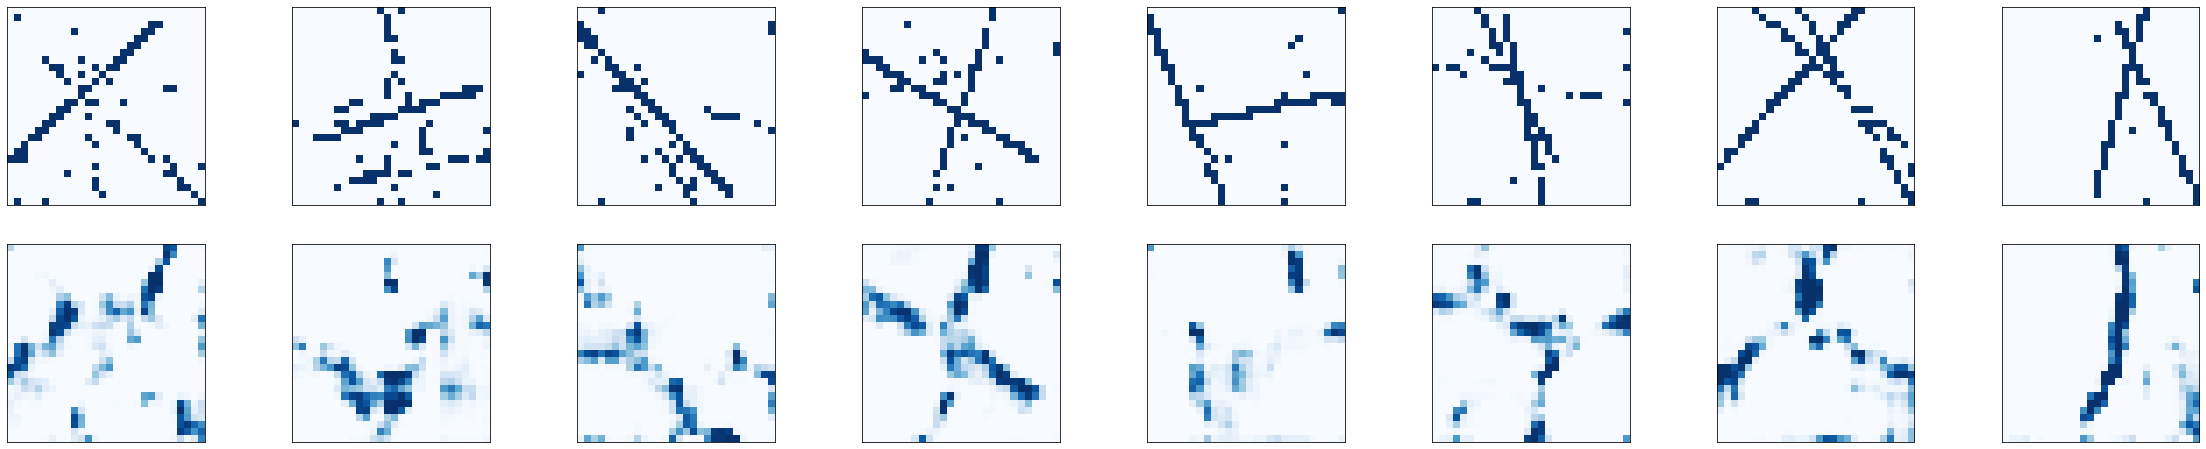

In [7]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 8  # how many samples we will display
plt.figure(figsize=(40, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    if map_to_grid:
        original = x_test[i].reshape((resX, resY))
        plt.imshow(original, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(original)[0]+0.5,0.5,np.shape(original)[1]+0.5))
    else:
        #original = x_test[i].reshape(round(input_size/2), 2)
        original = x_test[i].reshape(input_size[0:2])
        plt.scatter(original[:, 0], original[:, 1], cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    if map_to_grid:
        reconstruction = decoded_imgs[i].reshape((resX, resY))
        plt.imshow(reconstruction, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(reconstruction)[0]+0.5,0.5,np.shape(reconstruction)[1]+0.5))
    else:
        #reconstruction = decoded_imgs[i].reshape(round(input_size/2), 2)
        reconstruction = decoded_imgs[i].reshape(input_size[0:2])
        plt.scatter(reconstruction[:, 0], reconstruction[:, 1], cmap='Blues')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

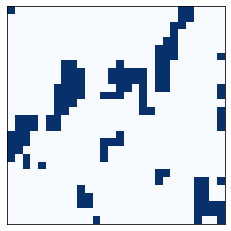

In [8]:
# if we use a threshold and remove values below say 0.2, we still don't have really sharp lines
highlight = decoded_imgs[0].reshape((resX, resY))
norm_reconstruction = highlight>0.2;
norm_fig = plt.imshow(norm_reconstruction, interpolation='nearest', cmap='Blues', extent=(0.5,np.shape(norm_reconstruction)[0]+0.5,0.5,np.shape(norm_reconstruction)[1]+0.5))
norm_fig.axes.get_xaxis().set_visible(False)
norm_fig.axes.get_yaxis().set_visible(False)


In [9]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

#z_mu_base = np.random.rand(1, encoding_dim);

z_select = np.arange(encoding_dim)
np.random.shuffle(z_select)

z_mu_all = encoder.predict(x_test)
z_mu_base0 = np.reshape(z_mu_all[z_select[0]], (1, encoding_dim))
z_mu_base1 = np.reshape(z_mu_all[z_select[1]], (1, encoding_dim))
z_mu_base2 = np.reshape(z_mu_all[z_select[2]], (1, encoding_dim))
z_mu_base3 = np.reshape(z_mu_all[z_select[3]], (1, encoding_dim))

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        #z_mu = np.array([[xi, yi]]) # only for 2 dim
        # Show interpolations between four randomly chosen digits from the test set 
        z_mu = z_mu_base0 * ((xi + 3)/6)*(1-(yi + 3)/6) + z_mu_base1 * (1-(xi + 3)/6)*((yi + 3)/6)
        z_mu += z_mu_base2 * ((xi + 3)/6)*((yi + 3)/6) + z_mu_base3 * (1-(xi + 3)/6)*(1-(yi + 3)/6)
        x_mean = decoder.predict(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

TypeError: arange: scalar arguments expected instead of a tuple.

In [ ]:
# The density of the layer with latent variables (not sparse!)
encoded_imgs.mean()

In [ ]:
# First layer [0] is empty array []. Second [1] and third [2] layers have weights and biases.
print("Number of layers:", len(autoencoder.layers))
weights = autoencoder.layers[2].get_weights()[0]
biases = autoencoder.layers[2].get_weights()[1]
print(weights)
print(biases)